In [1]:
%load_ext autotime

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
from pprint import pprint

time: 1.31 s


In [3]:
import sys
sys.path.extend(["../"])
from core.tools.data_import import *
from core.tools.time_series import *
from core.tools.visualize import *
from core.models.baseline_rnn import *
from constants import *

time: 3.51 ms


In [4]:
# Select a source of file.
pprint(UNRATE_DIR)
# file_dir_selected = input("Select Directory ")
file_dir_selected = "EC2"

{'EC2': '/home/ec2-user/code/AnnEconForecast/data/UNRATE.csv',
 'MAC': '/Users/tianyudu/Documents/Academics/EconForecasting/AnnEconForecast/data/UNRATE.csv'}
time: 780 µs


In [5]:
# Pre-processing Parameters
PERIODS = 1
ORDER = 1
LAGS = 48

time: 419 µs


In [6]:
df = load_dataset(UNRATE_DIR[file_dir_selected])
prepared_df = differencing(df, periods=PERIODS, order=ORDER)
prepared_df.head()

Dataset loaded.    
	Index type: datetime64[ns]    
	Data type: float64


,UNRATE_period1_order1
DATE,
1948-01-01,NaN
1948-02-01,0.4
1948-03-01,0.2
1948-04-01,-0.1
1948-05-01,-0.4


time: 21.4 ms


In [7]:
X_raw, y_raw = gen_supervised_sequence(
    prepared_df, LAGS, prepared_df.columns[0], sequential_label=False)

Total 800 observations generated.
Note: shape format: (num_obs, time_steps, num_inputs/outputs)
X shape = (800, 48, 1), y shape = (800, 1, 1)
time: 57.8 ms


In [58]:
X_raw = X_raw.reshape(-1, LAGS,)
y_raw = y_raw.reshape(-1, LAGS,)
print(X_raw.shape, y_raw.shape)

ValueError: cannot reshape array of size 836 into shape (12)

time: 8.27 ms


In [72]:
(X_train, X_test,
 y_train, y_test) = train_test_split(
    X_raw, y_raw,
    test_size=0.2,
    shuffle=False
)

(X_train, X_val,
 y_train, y_val) = train_test_split(
    X_train, y_train,
    test_size=0.2,
    shuffle=False
)

time: 1.53 ms


In [73]:
# Expand dimension so it fits the RNN input place holder.
# (Num_Sample, time_steps, 1)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

time: 646 µs


In [74]:
y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

time: 623 µs


In [75]:
print(f"Training and testing set generated,\
\nX_train shape: {X_train.shape}\
\ny_train shape: {y_train.shape}\
\nX_test shape: {X_test.shape}\
\ny_test shape: {y_test.shape}\
\nX_validation shape: {X_val.shape}\
\ny_validation shape: {y_val.shape}")

Training and testing set generated,
X_train shape: (512, 48, 1, 1)
y_train shape: (512, 1, 1, 1)
X_test shape: (160, 48, 1, 1)
y_test shape: (160, 1, 1, 1)
X_validation shape: (128, 48, 1, 1)
y_validation shape: (128, 1, 1, 1)
time: 659 µs


ValueError: x and y can be no greater than 2-D, but have shapes (1,) and (1, 1, 1)

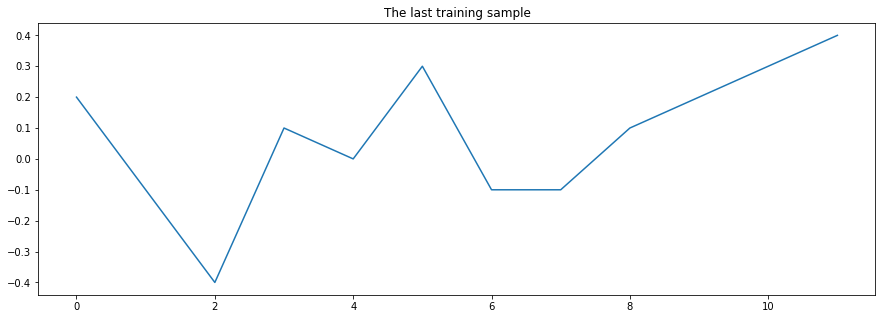

time: 202 ms


In [51]:
# One Sample
plt.figure(figsize=(15, 5))
plt.title("The last training sample")
plt.plot(X_train[1])
plt.plot(y_train[0], "-o")
plt.legend(["X", "y"])
plt.grid(True)
plt.show()

In [14]:
# Model Parameters
num_time_steps = LAGS
# Number of series used to predict. (including concurrent)
num_inputs = 1
num_outputs = 1
num_neurons = 512
# Number of output series
learning_rate = 0.01
epochs = 10000
# Training Settings
report_periods = 1000

time: 618 µs


In [15]:
parameters = {
    "num_time_steps": LAGS,
    "num_inputs": 1,
    "num_outputs": 1,
    "num_neurons": 64,
    "learning_rate": 0.1
}

time: 988 µs


In [16]:
model = BaselineRnn(para=parameters, sequential_label=True)

Model: loading parameters
Building placeholders...
Building core rnn...
Building metrics and operations...
time: 4.24 s


In [17]:
hist = {"train": [], "val": []}
with tf.Session() as sess:
    sess.run(model.init)
    for e in range(epochs):
        progbar(e, epochs-1, epochs//10)
        sess.run(model.train,
                 feed_dict={model.X: X_train, model.y: y_train})
        if e % report_periods == 0:
            eval_loss = lambda pred, resp: model.loss.eval(
                feed_dict={model.X: pred, model.y: resp})
            train_mse = eval_loss(X_train, y_train)
            val_mse = eval_loss(X_val, y_val)
            hist["train"].append(train_mse)
            hist["val"].append(val_mse)
            print(f"\nIteration [{e}], Training MSE {train_mse:0.7f}; Validation MSE {val_mse:0.7f}")
    
    gen_pred = lambda src: model.outputs.eval(feed_dict={model.X: src})[:,-1]
    p_train = gen_pred(X_train)
    p_test = gen_pred(X_test)

 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

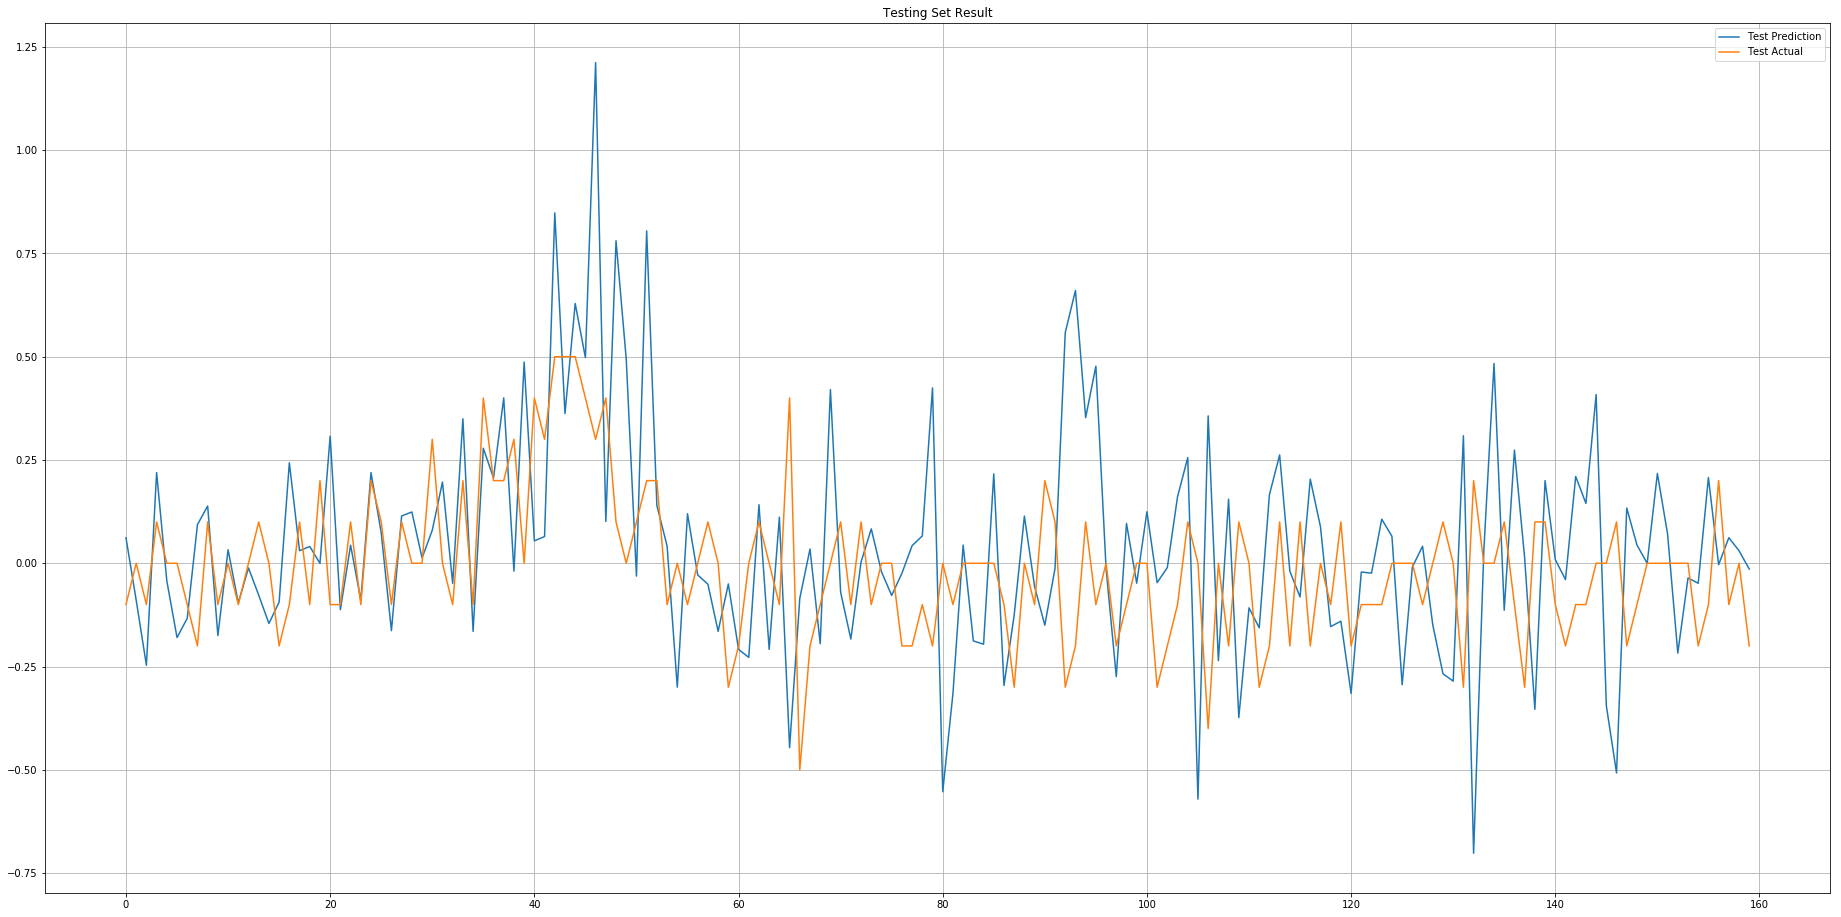

time: 642 ms


In [19]:
# Visualize testing set result
plt.close()
plt.figure(figsize=(32,16))
plt.title("Testing Set Result")
plt.plot(np.squeeze(p_test[:,-1]))
plt.plot(np.squeeze(y_test[:,-1]))
plt.legend(["Test Prediction", "Test Actual"])
plt.grid(True)
plt.show()

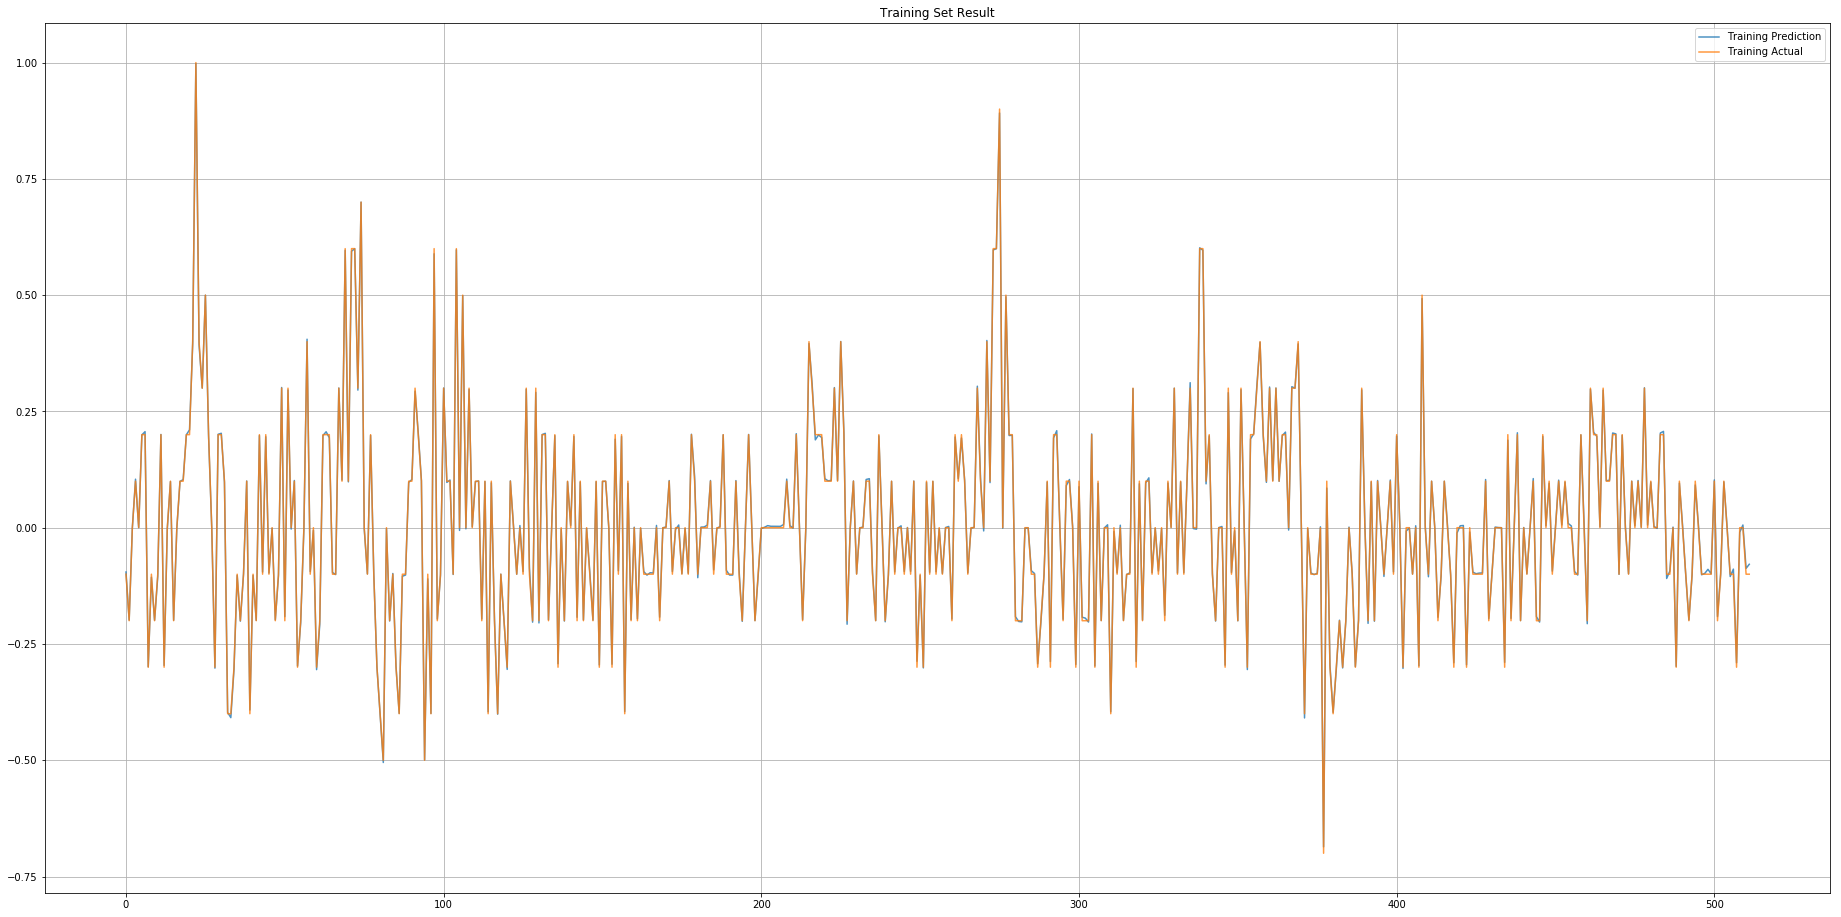

time: 676 ms


In [20]:
# Visualize training set result
plt.close()
plt.figure(figsize=(32,16))
plt.title("Training Set Result")
plt.plot(np.squeeze(p_train), alpha=0.8)
plt.plot(np.squeeze(y_train[:,-1]), alpha=0.8)
plt.legend(["Training Prediction", "Training Actual"])
plt.grid(True)
plt.show()

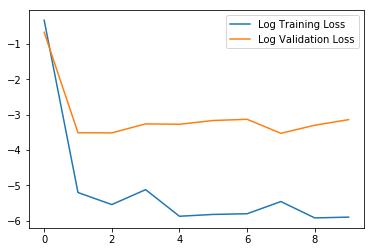

time: 123 ms


In [21]:
plt.close()
plt.plot(np.log(hist["train"]))
plt.plot(np.log(hist["val"]))
plt.legend(["Log Training Loss", "Log Validation Loss"])
plt.show()